Toxic and Bigoted Language in Online Comments

This notebook explores how toxic and identity-based abusive language appear in online discussion data. I use the Civil Comments dataset, which contains millions of comments with toxicity scores, and perform basic data cleaning, exploratory analysis, clustering, and hypothesis testing.

Step 1: Load the dataset

I use the `google/civil_comments` dataset from Hugging Face. Each row represents an online comment, along with numeric labels for toxicity and other attributes such as insults, threats, and identity attacks. I only need the `train` split, which already contains toxicity scores for each comment.

Libraries and setup

Before starting, I import the Python libraries I’ll use throughout the notebook.

- datasets: to load the Civil Comments dataset directly from Hugging Face.  
- pandas and numpy: for general data manipulation and handling.  
- scikit-learn (TfidfVectorizer, KMeans, CountVectorizer):  
  - TfidfVectorizer turns text into numerical features based on word frequency.  
  - KMeans groups similar comments together into clusters.  
  - CountVectorizer helps find the most frequent words in certain clusters.  
- scipy.stats (f_oneway, ttest_ind): to perform statistical tests (ANOVA and t-test).  
- matplotlib and seaborn: for data visualization and clean plots.

Finally, I set Seaborn’s style to "whitegrid" for a cleaner look in the charts.


In [8]:
from datasets import load_dataset
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import f_oneway, ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [9]:
dataset = load_dataset("google/civil_comments")
train = dataset["train"].to_pandas()

print("Number of rows:", len(train))
train.head()


Number of rows: 1804874


,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


Step 2: Cleaning the data and selecting variables

Some rows in the dataset have empty text, so I remove those. I then keep only the columns that contain the text and toxicity-related scores.

In [10]:
# Drop rows where text is missing or empty
df = train.dropna(subset=["text"])
df = df[df["text"].str.strip() != ""]

# Keep only the columns I care about
cols = [
    "text",
    "toxicity",
    "severe_toxicity",
    "obscene",
    "threat",
    "insult",
    "identity_attack",
    "sexual_explicit",
]
df = df[cols]

df.head()


,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


Step 3: Defining toxic and bigoted comments
The dataset gives scores between 0 and 1. I treat a comment as "toxic" if `toxicity >= 0.5`, and as "bigoted" (if it contains identity-based abuse) if `identity_attack >= 0.5`. Here I just take a 100k sample so things run faster. I chose 0.5 as a threshold because it splits the neutral comments from clearly toxic.

In [19]:
TOX_THRESHOLD = 0.5

df["is_toxic"] = df["toxicity"] >= TOX_THRESHOLD
df["is_bigoted"] = df["identity_attack"] >= TOX_THRESHOLD

# 100k sample for faster experiments
sample = df.sample(100_000, random_state=42)

sample[["is_toxic", "is_bigoted"]].mean()


is_toxic      0.07938
is_bigoted    0.00769
dtype: float64

A bar graph for better visualisation of proportions

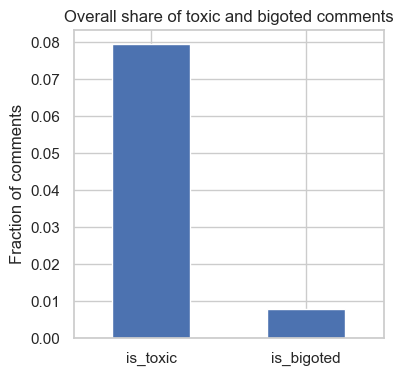

In [12]:
rates = sample[["is_toxic", "is_bigoted"]].mean()

plt.figure(figsize=(4, 4))
rates.plot(kind="bar")
plt.ylabel("Fraction of comments")
plt.title("Overall share of toxic and bigoted comments")
plt.xticks(rotation=0)
plt.show()


Step 4: Clustering the comments into groups

I do not have explicit news outlet IDs in this version of the dataset. I was struggling on how to tackle this so I resorted to ChatGPT for ideas and grouping comments by text similarity seemed the most plausible to me. This helps simulate different conversation spaces since everyone is discussing similar things. Number of clusters being 20 seemed like a middle point between detail and simplicity. More clusters would give me a more deeper dive into the details but it would also be harder for me to interpret. To implement the TF–IDF features and K-means clustering in python I had some assistance from ChatGPT. Each cluster describes a different type of discussion.


In [13]:
vectorizer = TfidfVectorizer(
    max_features=20_000,   
    ngram_range=(1, 2),
    min_df=5
)

X = vectorizer.fit_transform(sample["text"])

N_CLUSTERS = 20
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init="auto"
)

sample["cluster"] = kmeans.fit_predict(X)
sample[["cluster"]].head()


,cluster
286892,14
419218,4
1055330,12
1382764,4
256049,1


Step 5: Toxicity by cluster

For each cluster I compute:
- number of comments,
- fraction of toxic comments,
- fraction of bigoted comments,
- average toxicity score.

This helps identify which clusters are the most toxic.


In [14]:
cluster_stats = (
    sample
    .groupby("cluster")
    .agg(
        n_comments=("text", "size"),
        tox_rate=("is_toxic", "mean"),
        bigoted_rate=("is_bigoted", "mean"),
        avg_toxicity=("toxicity", "mean"),
        avg_identity_attack=("identity_attack", "mean")
    )
    .reset_index()
    .sort_values("cluster")
)

cluster_stats


,cluster,n_comments,tox_rate,bigoted_rate,avg_toxicity,avg_identity_attack
0,0,3929,0.089845,0.006363,0.111104,0.019697
1,1,3507,0.125463,0.007129,0.149918,0.023183
2,2,3790,0.066491,0.006596,0.084680,0.018006
3,3,2151,0.107857,0.010228,0.125638,0.025132
4,4,5579,0.090518,0.010038,0.115487,0.030460
5,5,1225,0.066939,0.008163,0.096027,0.023549
6,6,7979,0.066800,0.007520,0.091860,0.021694
7,7,3161,0.057893,0.005062,0.084683,0.019136
8,8,2132,0.101313,0.007036,0.123389,0.022014
9,9,6758,0.115863,0.007843,0.133612,0.022770


**Visualizing differences between clusters**
These bar charts show how toxicity and identity-based bigotry vary across clusters.
Some clusters stand out as more toxic, while others stay around the overall average.

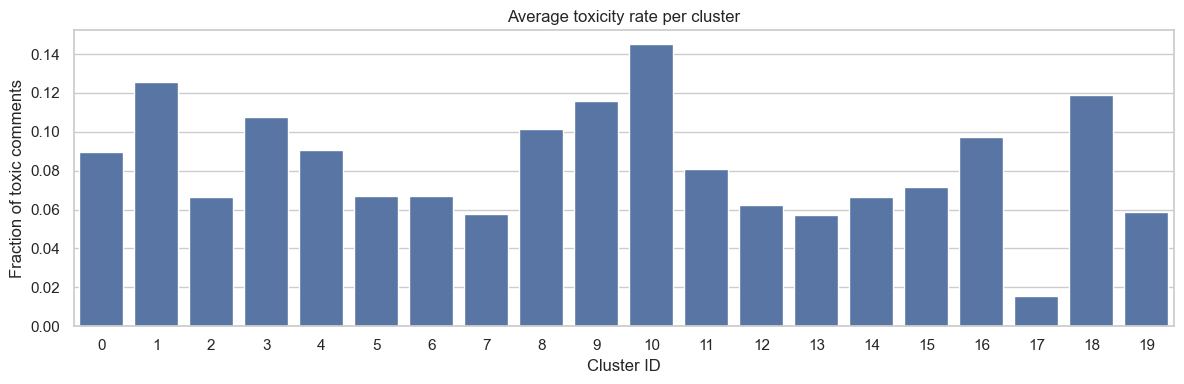

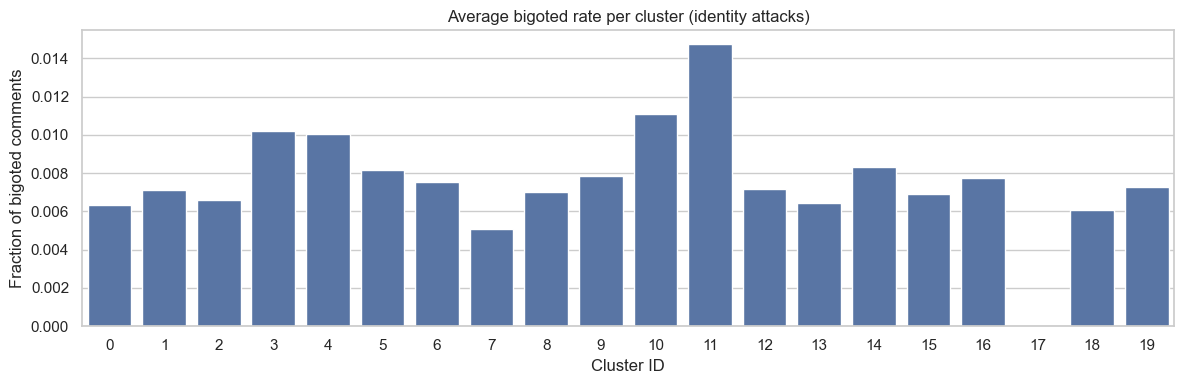

In [15]:
# Toxicity rate per cluster
plt.figure(figsize=(12, 4))
sns.barplot(
    data=cluster_stats.sort_values("tox_rate", ascending=False),
    x="cluster", y="tox_rate"
)
plt.title("Average toxicity rate per cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Fraction of toxic comments")
plt.tight_layout()
plt.show()

# Bigoted rate per cluster
plt.figure(figsize=(12, 4))
sns.barplot(
    data=cluster_stats.sort_values("bigoted_rate", ascending=False),
    x="cluster", y="bigoted_rate"
)
plt.title("Average bigoted rate per cluster (identity attacks)")
plt.xlabel("Cluster ID")
plt.ylabel("Fraction of bigoted comments")
plt.tight_layout()
plt.show()


In the first graph, cluster ids 1, 10 and 11 show the highest toxicity rate while in the second graph, the clusters 3, 4, 10 and 11 present higher average bigoted rate. These clusters are more likely to be argumentative or political in nature.

Step 6: Hypothesis testing
Hypothesis test: do clusters differ in toxicity?

Null hypothesis: all clusters have the same average toxicity score.  
Alternative: at least one cluster has a different mean toxicity.

I run a one-way ANOVA on the `toxicity` score, grouped by cluster. For the implementation of ANOVA below, I had assistance from ChatGPT. 

In [16]:
groups = []
for c in range(N_CLUSTERS):
    group_scores = sample.loc[sample["cluster"] == c, "toxicity"]
    groups.append(group_scores)

f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F = {f_stat:.3f}, p-value = {p_val:.4g}")


ANOVA F = 60.152, p-value = 0


The ANOVA test gives F = 60.152, p = 0, meaning toxicity differs significantly between at least some clusters.

I also compare the most toxic cluster with the least toxic one using a two-sample t-test. If the p-value is below 0.05, that means the difference is statistically significant.

In [17]:
# finding IDs of most and least toxic clusters
most_toxic_id = cluster_stats.sort_values("tox_rate", ascending=False).iloc[0]["cluster"]
least_toxic_id = cluster_stats.sort_values("tox_rate", ascending=True).iloc[0]["cluster"]

print("Most toxic cluster:", most_toxic_id)
print("Least toxic cluster:", least_toxic_id)

scores_high = sample.loc[sample["cluster"] == most_toxic_id, "toxicity"]
scores_low = sample.loc[sample["cluster"] == least_toxic_id, "toxicity"]

t_stat, p_val_t = ttest_ind(scores_high, scores_low, equal_var=False)
print(f"T-test between most and least toxic clusters: t = {t_stat:.3f}, p = {p_val_t:.4g}")


Most toxic cluster: 10.0
Least toxic cluster: 17.0
T-test between most and least toxic clusters: t = 14.090, p = 8.04e-43


As seen from the results above, the difference is statistically significant.

Step 8: Inspect example comments and common words

To understand what these clusters represent, I look at some example comments from the most toxic cluster and the most frequent words in the most and least toxic clusters. This gives me an idea on the themes that drive higher toxicity.

In [18]:
# few examples from the most toxic cluster
example_rows = sample[sample["cluster"] == most_toxic_id].head(5)
for i, row in example_rows.iterrows():
    print("----")
    print("Toxic:", row["is_toxic"], "Bigoted:", row["is_bigoted"])
    print(row["text"])

# most common words in the most toxic vs least toxic cluster
high_tox_text = sample.loc[sample["cluster"] == most_toxic_id, "text"]
low_tox_text = sample.loc[sample["cluster"] == least_toxic_id, "text"]

cv = CountVectorizer(stop_words="english", max_features=20)

high_words = cv.fit(high_tox_text).get_feature_names_out()
low_words = cv.fit(low_tox_text).get_feature_names_out()

print("\nTop words (most toxic cluster):", high_words)
print("Top words (least toxic cluster):", low_words)

----
Toxic: False Bigoted: False
I'm only stopping by to see how many Trump supporters confuse there, their and they're, as well as your, yore and you're, and how many also misuse the possessive form and/or commit other egregious spelling and grammar errors.  

Don't let me down gang.
----
Toxic: False Bigoted: False
Totally wrong. The players spit in the faces of any and all true fans. 
'Commendable cause'??? Not in a million years. And you're certainly not qualified to speak for any Bronco fan. Get over yourself...
----
Toxic: False Bigoted: False
You don't know what you're talking about, whatever-your-name-for-the-day is. You can't stay on point and have no understanding of scripture or history, and certainly no understanding of Judaism. So forgive me if I prefer what I learned in Rome to what you're trying to pass off here. Bye.
----
Toxic: False Bigoted: False
If you're happy with what you've got, that's all that really matters.
----
Toxic: False Bigoted: False
Just say you're hom

**What the results show**

The ANOVA test shows that toxicity differs significantly between clusters (p < 0.001), meaning not all groups of discussion are toxic.

When checking common words, the most toxic cluster contains mostly **political** terms like “clinton”, “donald”, “hillary”, and “trump”, suggesting that political debates are more likely to include aggressive or toxic comments.

The least toxic clusters contain more **neutral or positive** language, including words like “good”, “great”, “thanks”, and “article”.  
Overall, this supports the idea that certain topics—especially political ones—attract more hostility than others.
